In [2]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Dataset

In [3]:
datasets = load_dataset('financial_phrasebank', 'sentences_allagree', split='train').train_test_split(test_size=0.2, seed=200)
train_dataset = datasets['train']
test_dataset = datasets['test']

Found cached dataset financial_phrasebank (C:/Users/abhir/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Loading cached split indices for dataset at C:\Users\abhir\.cache\huggingface\datasets\financial_phrasebank\sentences_allagree\1.0.0\550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141\cache-8c7f4c3ea87ee460.arrow and C:\Users\abhir\.cache\huggingface\datasets\financial_phrasebank\sentences_allagree\1.0.0\550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141\cache-6c1322cac04d258a.arrow


In [4]:
train_dataset.set_format(type='torch', columns=['sentence', 'label'])
test_dataset.set_format(type='torch', columns=['sentence', 'label'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

# Machine Learning Models

In [5]:
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

X_train, y_train = train_df['sentence'], train_df['label']
X_test, y_test = test_df['sentence'], test_df['label']

### TFIDF Pre-processing

In [6]:
vectorizer_tfidf = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None, stop_words=stopwords.words("english"))
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

C:\Users\abhir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


### Models

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

In [8]:
target_names = ['positive', 'negative', 'neutral']

In [9]:
models_tfidf = {
    "Logistic Reg.": LogisticRegression(max_iter=1000),
    "SVM": svm.SVC(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "XG Boost": XGBClassifier()
}

In [10]:
model_accuracy_df = pd.DataFrame(columns=['model', 'accuracy', 'f1', 'time_taken'])

In [11]:
for label, model  in models_tfidf.items():
    model.fit(X_train_tfidf, y_train)
    t0 = time.time()
    y_pred = model.predict(X_test_tfidf)
    time_taken = time.time() - t0

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, target_names = target_names)
    model_accuracy_df = pd.concat([model_accuracy_df, pd.DataFrame([{'model': label, 'accuracy': accuracy, 'f1': f1, 'time_taken': time_taken}])], ignore_index=True)
    print(f"Model Name: {label} | Pre Preprocessing Method: TFIDF")
    print(f'F1 Score: {f1 * 100:.2f}%')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Classification report:\n{report}')
    print("-"*50)

Model Name: Logistic Reg. | Pre Preprocessing Method: TFIDF
F1 Score: 79.33%
Accuracy: 81.02%
Classification report:
              precision    recall  f1-score   support

    positive       0.84      0.42      0.56        64
    negative       0.81      0.99      0.89       268
     neutral       0.79      0.63      0.70       121

    accuracy                           0.81       453
   macro avg       0.82      0.68      0.72       453
weighted avg       0.81      0.81      0.79       453

--------------------------------------------------
Model Name: SVM | Pre Preprocessing Method: TFIDF
F1 Score: 78.10%
Accuracy: 79.91%
Classification report:
              precision    recall  f1-score   support

    positive       0.81      0.41      0.54        64
    negative       0.81      0.98      0.89       268
     neutral       0.76      0.60      0.67       121

    accuracy                           0.80       453
   macro avg       0.79      0.66      0.70       453
weighted avg      

## Model Comparison



In [12]:
model_accuracy_df

,model,accuracy,f1,time_taken
0,Logistic Reg.,0.810155,0.793333,0.000000
1,SVM,0.799117,0.781009,0.171960
2,Random Forest,0.821192,0.806991,0.053860
3,XG Boost,0.854305,0.847922,0.003225


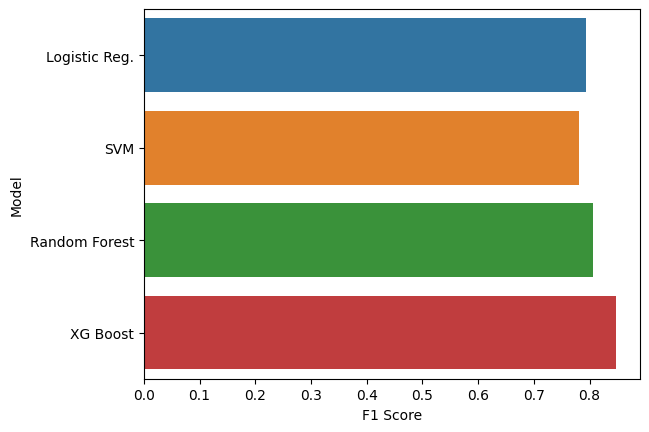

In [13]:
fig = sns.barplot(model_accuracy_df, y="model", x="f1", orient="h")
fig.set(xlabel='F1 Score', ylabel='Model')
plt.show()

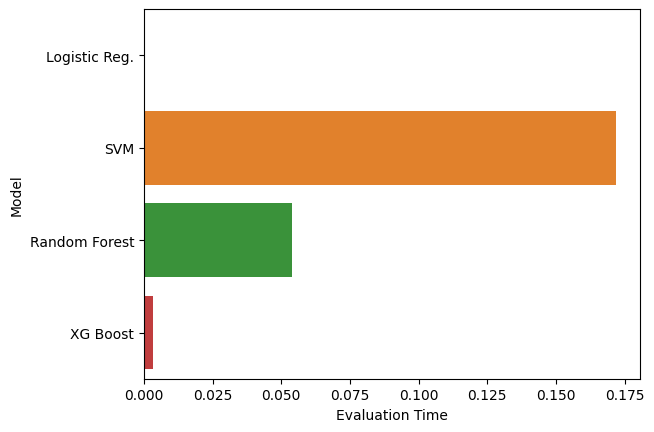

In [14]:
fig = sns.barplot(model_accuracy_df, y="model", x="time_taken", orient="h")
fig.set(xlabel='Evaluation Time', ylabel='Model')
plt.show()

## Misclassified Sentences by Length

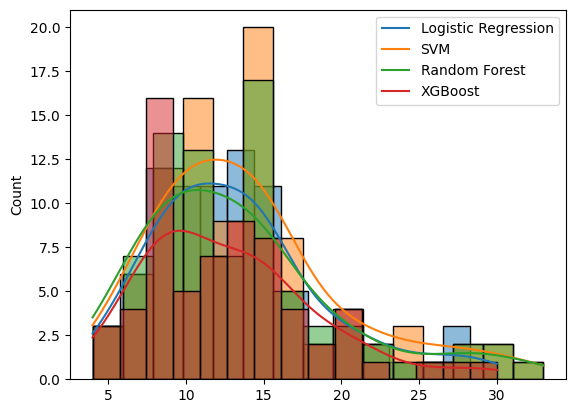

Average Misclassified Word Length: 13.38 | Min Avg.: 12.79 | Max Avg.: 13.93


In [22]:
total_avg = []
for label, model  in models_tfidf.items():
    y_pred = model.predict(X_test_tfidf)
    misc_sentences = vectorizer_tfidf.inverse_transform(X_test_tfidf[y_pred != y_test])
    misc_len_dist = [len(sentence) for sentence in misc_sentences]
    total_avg.append(sum(misc_len_dist) / len(misc_len_dist))
    sns.histplot(misc_len_dist, kde=True, bins=15)
plt.legend(["Logistic Regression", "SVM", "Random Forest", "XGBoost"])
plt.show()
print(f"Average Misclassified Word Length: {sum(total_avg)/len(total_avg):.2f} | Min Avg.: {min(total_avg):.2f} | Max Avg.: {max(total_avg):.2f}")

C:\Users\abhir\AppData\Local\Temp\ipykernel_21184\3947321251.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120])


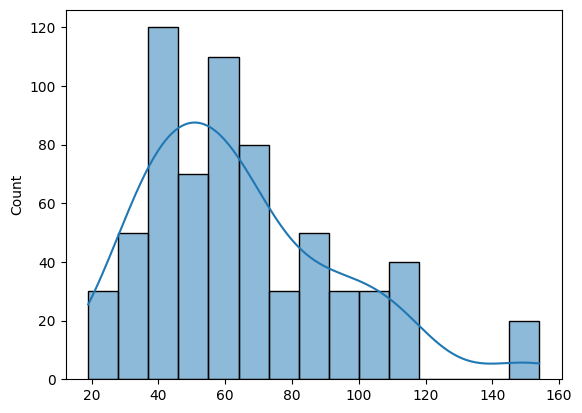

Average Misclassified Character Length: 64.53 | Min Avg.: 64.53 | Max Avg.: 64.53


In [35]:
total_avg = []
for label, model  in models_tfidf.items():
    if label == 'XG Boost':
        for i in range(10):
            y_pred = model.predict(X_test_tfidf)
            misc_sentences = vectorizer_tfidf.inverse_transform(X_test_tfidf[y_pred != y_test])
            misc_len_dist = [len("".join(sentence)) for sentence in misc_sentences]
            total_avg.append(sum(misc_len_dist) / len(misc_len_dist))
        ax = sns.histplot(misc_len_dist, kde=True, bins=15)

ax.set_yticklabels([0, 20, 40, 60, 80, 100, 120])
plt.show()
print(f"Average Misclassified Character Length: {sum(total_avg)/len(total_avg):.2f} | Min Avg.: {min(total_avg):.2f} | Max Avg.: {max(total_avg):.2f}")

## Misclassified Examples

In [24]:
y_pred = models_tfidf['XG Boost'].predict(X_test_tfidf)
misclassified = X_test[y_pred != y_test]
sentiment = ['Negative', 'Neutral', 'Positive']

for idx, sentence in misclassified[:5].items():
    print(sentence)
    print("Actual:", sentiment[y_test[idx]])
    print("Prediction:", sentiment[y_pred[idx]], "\n")

Scanfil issued a profit warning on 10 April 2006 .
Actual: Negative
Prediction: Neutral 

Cerberus Capital Management LP-backed printing paper maker NewPage Corp. has posted mixed second-quarter results , casting a cloud over its planned initial public offering .
Actual: Negative
Prediction: Neutral 

Cash flow from business operations totalled EUR 0.4 mn compared to a negative EUR 15.5 mn in the first half of 2008 .
Actual: Positive
Prediction: Negative 

Finnish-Swedish TietoEnator is expanding its business quickly in Russia .
Actual: Positive
Prediction: Neutral 

According to Finnair Technical Services , the measure is above all due to the employment situation .
Actual: Neutral
Prediction: Negative 



C:\Users\abhir\AppData\Local\Temp\ipykernel_16060\3601124016.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for idx, sentence in misclassified[:5].items():
